In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression,RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import category_encoders as ce


from scipy.stats import randint, uniform
from scipy.stats import loguniform


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif
)

from sklearn.svm import SVC



from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    log_loss,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score
)

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [3]:
# new_features = ['funeral_insurance_bin', 'insurance_age', 'has_loan_account_bin', 'high_compliance_record', 'owner_age_country_C', 'has_insurance_country_B', 'financial_access_score', 'has_insurance_country_C', 'medical_insurance_bin', 'insurance_ratio', 'debt_ratio', 'financial_access_country', 'owner_age_country_A', 'insurance_count', 'owner_age_country_B', 'financial_formality_index', 'age_country', 'insurance_coverage_score', 'has_insurance_bin', 'has_credit_card_bin', 'has_insurance_country_D', 'digital_finance_score', 'uses_credit', 'insurance_country_weighted', 'financial_strength_index', 'motor_vehicle_insurance_bin', 'credit_intensity', 'has_insurance_country_A', 'attitude_optimism_score', 'insurance_country', 'cash_flow_ratio', 'owner_age_country_D', 'total_economic_capacity', 'profit_margin', 'record_keeping_ord']

# keep = ['profit_margin', 'total_economic_capacity', 'age_country', 'cash_flow_ratio', 'insurance_age', 'insurance_coverage_score' 'isnurance_ratio', 'insurance_country_weighted', 'insurance_count']

# to_drop = list(set(new_features) - set(keep))

# X_train = X_train.drop(columns=to_drop, errors='ignore')

# # Optionally, do the same for X_test
# X_test = X_test.drop(columns=to_drop, errors='ignore')

In [4]:
X_train.shape

(7694, 68)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

In [6]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()



#### Numeric Pipeline

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.caps_ = {}

    def fit(self, X, y=None):
        # handle both DataFrame and array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        for i, col in enumerate(X.columns):
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.caps_[i] = (Q1 - self.factor*IQR, Q3 + self.factor*IQR)  # store by index
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X = X.copy()
        for i, col in enumerate(X.columns):
            lower, upper = self.caps_[i]
            X[col] = X[col].clip(lower, upper)
        return X.values  # return as array for compatibility


In [8]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler


log_cols = ['owner_age']  # columns to apply log1p
yj_cols = ['business_expenses', 'personal_income', 'business_turnover', 'business_age_years']


# log1p pipeline
log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('cap', OutlierCapper(factor=1.5)),
    ('scaler', MinMaxScaler()),
    ('standard', StandardScaler()) 
])

yj_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('cap', OutlierCapper(factor=1.5)),
    ('scaler', MinMaxScaler()),  # optional if needed
    ('standard', StandardScaler()) 

])

other_numeric_cols = [col for col in num_cols if col not in yj_cols]


other_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('standard', StandardScaler())
])




#### Categorical Pipeline

In [9]:
target_encode_cols = ['funeral_insurance', 'medical_insurance', 
            'motor_vehicle_insurance', 'has_credit_card', 'keeps_financial_records']  # replace with your chosen cols
onehot_cols = [c for c in cat_cols if c not in target_encode_cols]



# Target encoding pipeline
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.SumEncoder())
])



# One-hot encoding pipeline
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log_num', log_pipeline, log_cols),
        ('yj_num', yj_pipeline, yj_cols),
        ('num', other_num_pipeline, num_cols),
        ('target', target_pipeline, target_encode_cols),
        ('onehot', onehot_pipeline, onehot_cols)
    ],
    remainder='passthrough'
)


# Remove near-constant features
variance_filter = VarianceThreshold(threshold=0.01)


# Statistical feature selectio
feature_selector = SelectKBest(
    score_func=f_classif,
    k=300    # tuneable
)


# Full Pipline

In [17]:
from sklearn.base import clone
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import KernelPCA
from imblearn.over_sampling import SMOTE

def build_pipeline(model):
    """
    Wraps preprocessing + model in a single pipeline
    """
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('variance_filter', variance_filter),
        # ('smote', SMOTE(sampling_strategy="not majority", random_state=42)),
        # ('feature_selection', feature_selector),
        # ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
        ('model', model),

    ])
    return pipeline


In [12]:
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.neighbors import NearestCentroid, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from scipy.stats import loguniform
from sklearn.decomposition import PCA


base_models = {
    'logistic': {
        'model': LogisticRegression(
            solver='lbfgs',          # fastest + stable
            max_iter=1000,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__C': [0.1, 1, 10],     # MOST important
            'model__fit_intercept': [True]
        }
    },
    'sgd': {
        'model': SGDClassifier(
            max_iter=2000,
            tol=1e-3,
            random_state=42
        ),
        'params': {
            'model__loss': ['log_loss', 'hinge'],
            'model__alpha': [1e-4, 1e-3, 1e-2],   # regularization strength
            'model__penalty': ['l2']
        }
    },
    'svm_rbf': {
        'model': SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            'model__C': [1, 10],
            'model__gamma': ['scale', 0.01]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [5, 15, 30],
            'model__weights': ['uniform', 'distance']
        }
    },
    # 'random_forest': {
    #     'model': RandomForestClassifier(
    #         random_state=42,
    #         n_jobs=-1,
    #         class_weight='balanced'
    #     ),
    #     'params': {
    #         'model__n_estimators': [100, 300],
    #         'model__max_depth': [None, 10],
    #         'model__max_features': ['sqrt']
    #     }
    # },
    # # 🌲 LightGBM
    # 'lightgbm': {
    #     'model': LGBMClassifier(
    #         random_state=42,
    #         n_jobs=-1,
    #         class_weight='balanced'
    #     ),
    #     'params': {
    #         'model__n_estimators': [100, 300, 500],
    #         'model__num_leaves': [31, 50, 70],
    #         'model__learning_rate': [0.05, 0.1, 0.2],
    #         'model__subsample': [0.8, 1.0],
    #         'model__colsample_bytree': [0.8, 1.0]
    #     }
    # },


}

# Dictionary of models + param grids
models = {
    'logistic': {
        'model': LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',#saga
            max_iter=5000,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__C': loguniform(1e-3, 1e3),
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__fit_intercept': [True, False],
            'model__l1_ratio': [0, 0.5, 1]
        }
    },


        # 12️⃣ PCA + Logistic Regression pipeline
    # 'pca_logistic': {
    #     'model': Pipeline([
    #         ('pca', PCA()),
    #         ('logistic', LogisticRegression(
    #             multi_class='multinomial',
    #             solver='saga',
    #             max_iter=5000,
    #             n_jobs=-1
    #         ))
    #     ]),
    #     'params': {
    #         'pca__n_components': [5, 10, 15, 20],
    #         'logistic__C': loguniform(0.1, 100),
    #         'logistic__penalty': ['l1', 'l2', 'elasticnet'],
    #         'logistic__l1_ratio': [0, 0.5, 1]
    #     }
    # },
    'ridge': {
        'model': RidgeClassifier(),
        'params': {
            'model__alpha': loguniform(0.01, 10)
        }
    },

    'sgd': {
        'model': SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
        'params': {
            'model__loss': ['hinge', 'log', 'modified_huber'],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__alpha': loguniform(1e-5, 1e-1)
        }
    },

       # --- Naive Bayes ---
    
    #----------------
    # Error
    #---------------
    # 'gaussian_nb': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },

    # 'multinomial_nb': {
    #     'model': MultinomialNB(),
    #     'params': {'model__alpha':[0.1,0.5,1.0]}
    # },

    # 'bernoulli_nb': {
    #     'model': BernoulliNB(),
    #     'params': {'model__alpha':[0.1,0.5,1.0]}
    # },


    # 'passive_aggressive': {
    #     'model': PassiveAggressiveClassifier(max_iter=1000, random_state=42),
    #     'params': {'model__C': loguniform(0.1,10)
    #     }
    # },
    
    # -----------------
    # Error
    # -----------------
    # 'nusvc': {
    #     'model': NuSVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    #     'params': {'model__nu':[0.2,0.4,0.6,0.8], 'model__gamma': loguniform(1e-3,0.1)}
    # },

    # 'complement_nb': {'model': ComplementNB(), 'params': {'model__alpha':[0.1,0.5,1.0]}},
    # -----------------
    # Error
    # -----------------
    # 'categorical_nb': {'model': CategoricalNB(), 'params': {'model__alpha':[0.1,0.5,1.0]}},


    'svm_rbf': {
        'model': SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            # 'model__C': loguniform(1e-2, 1e3), for wider range
            # 'model_gamma': loguniform(1e-4, 10), for wider range
            "model__C": loguniform(0.1, 100),
            "model__gamma": loguniform(1e-3, 0.1)
        }
    },

#------------------
# This was good model
#------------------

    'svm_poly': {
        'model': SVC(
            kernel='poly',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            "model__C": loguniform(0.1, 100),          # regularization
            "model__degree": [2],             # polynomial degree
            "model__gamma": loguniform(1e-3, 0.1),     # kernel width
            "model__coef0": [0, 0.1, 0.5, 1]           # independent term in poly kernel
        }
    },


#------------------
# This was good model
#------------------
    # Too Much Time
    'svm_linear': {
        'model': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            'model__C': loguniform(0.1, 100) # loguniform(1e-2, 1e2)
        }
    },

    # -----------------
    # Error
    # -----------------
    # 'svm_calibrated': {
    #     'model': CalibratedClassifierCV(estimator=SVC(probability=True, kernel='rbf', random_state=42)),
    #     'params': {
    #         'base_estimator__C': loguniform(0.1,100), 
    #         'base_estimator__gamma': loguniform(1e-3,0.1)
    #     }
    # },

    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': randint(3, 50),        # number of neighbors
            'model__weights': ['uniform', 'distance'],   # weighting function
            'model__p': [1, 2]                           # 1 = Manhattan, 2 = Euclidean
        },
    },

    # -----------------
    # Error
    # -----------------
    # 'radius_neighbors': {
    #     'model': RadiusNeighborsClassifier(),
    #     'params': {
    #         'model__radius':[0.5,1.0,2.0]
    #     }
    # },
    
    # 'nearest_centroid': {
    #     'model': NearestCentroid(),
    #     'params': {}
    # },


    'lda': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'model__solver': ['svd', 'lsqr', 'eigen'],           # solver choices
            'model__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]      # only used with lsqr/eigen
        }
    },
#------------------
# Error
#------------------

    # 'kpca_lda': {   # <-- new pipeline entry
    #     'model': Pipeline([
    #         ('kpca', KernelPCA(random_state=42, fit_inverse_transform=False)),
    #         ('lda', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
    #     ]),
    #     'params': {
    #         'kpca__n_components': [5, 10, 15, 30],
    #         'kpca__kernel': ['rbf', 'poly'],
    #         'kpca__gamma': [0.01, 0.05, 0.1],
    #         'kpca__degree': [2, 3],           # only used for poly
    #         'lda__shrinkage': ['auto', 0.1, 0.5]
    #     }
    # },
    

    # -----------------
    # Error
    # -----------------
    # 'qda': {
    #     'model': QuadraticDiscriminantAnalysis(),
    #     'params': {
    #         'model__reg_param': [0.0, 0.1, 0.5]  # regularization for QDA
    #     }
    # },






    # # # 8️⃣ Random Forest
    # 'random_forest': {
    #     'model': RandomForestClassifier(
    #         random_state=42,
    #         n_jobs=-1
    #     ),
    #     'params': {
    #         'model__n_estimators': randint(100, 1000),
    #         'model__max_depth': [None, 5, 10, 20],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__min_samples_leaf': [1, 2, 4],
    #         'model__max_features': ['sqrt', 'log2', None]
    #     }
    # },

    # # # 9️⃣ Gradient Boosting
    # 'gradient_boosting': {
    #     'model': GradientBoostingClassifier(random_state=42),
    #     'params': {
    #         'model__n_estimators': randint(100, 1000),
    #         'model__learning_rate': loguniform(0.01, 0.5),
    #         'model__max_depth': [3, 5, 7, 10],
    #         'model__subsample': [0.6, 0.8, 1.0],
    #         'model__max_features': ['sqrt', 'log2', None]
    #     }
    # },

    # # 🔟 AdaBoost
    # 'adaboost': {
    #     'model': AdaBoostClassifier(random_state=42),
    #     'params': {
    #         'model__n_estimators': randint(50, 500),
    #         'model__learning_rate': loguniform(0.01, 1.0)
    #     }
    # },



    


}


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, log_loss,
    roc_auc_score, f1_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt




def train_and_evaluate(X_train, y_train, X_test, y_test, model_dict, n_iter=20, cv=5, plot_confusion=True, plot_importance=True):
    results = {}
    summary_list = []

    feature_names = X_train.columns.tolist()  # get column names for importance

    for name, cfg in model_dict.items():
        print(f"\n=== Training {name} ===")
        pipeline = build_pipeline(cfg['model'])

        search = RandomizedSearchCV(
            pipeline,
            param_distributions=cfg['params'],
            n_iter=n_iter,
            cv=cv,
            scoring='neg_log_loss',
            verbose=1,
            n_jobs=-1,
            random_state=42,
            refit=True
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Robust probability handling
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)
        else:
            y_proba = np.zeros((len(y_pred), len(np.unique(y_train))))
            for i, label in enumerate(y_pred):
                y_proba[i, label] = 1

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'log_loss': log_loss(y_test, y_proba),
            'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted')
        }

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        results[name] = {
            'best_model': best_model,
            'best_params': search.best_params_,
            'cv_score': search.best_score_,
            'metrics': metrics,
            'confusion_matrix': cm
        }

        # Add summary row
        summary_list.append({
            'Model': name,
            'CV Score': search.best_score_,
            'Accuracy': metrics['accuracy'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'Log Loss': metrics['log_loss'],
            'ROC AUC': metrics['roc_auc'],
            'F1 Weighted': metrics['f1_weighted']
        })

        print(f"Best params: {search.best_params_}")
        print(f"Metrics: {metrics}")

        # Plot confusion matrix
        if plot_confusion:
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()




    # Summary table
    summary_df = pd.DataFrame(summary_list)
    summary_df = summary_df.sort_values(by='ROC AUC', ascending=False)
    print("\n=== Summary Table ===")
    display(summary_df)

    return results, summary_df


### with one-hot only


=== Training logistic ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best params: {'model__C': 1.319496149042566, 'model__fit_intercept': False, 'model__l1_ratio': 0.5, 'model__penalty': 'l1'}
Metrics: {'accuracy': 0.8664241164241164, 'balanced_accuracy': 0.7511263797709512, 'log_loss': 0.3384450624242216, 'roc_auc': 0.9348558181116834, 'f1_weighted': 0.8596034968723975}


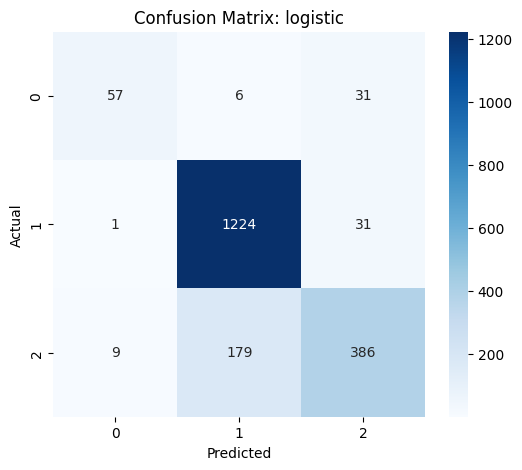


=== Training sgd ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__alpha': 0.0027541439213320286, 'model__loss': 'modified_huber', 'model__penalty': 'elasticnet'}
Metrics: {'accuracy': 0.8341995841995842, 'balanced_accuracy': 0.6254692429264138, 'log_loss': 0.9699747581436909, 'roc_auc': 0.8959802702873526, 'f1_weighted': 0.8169166037908799}


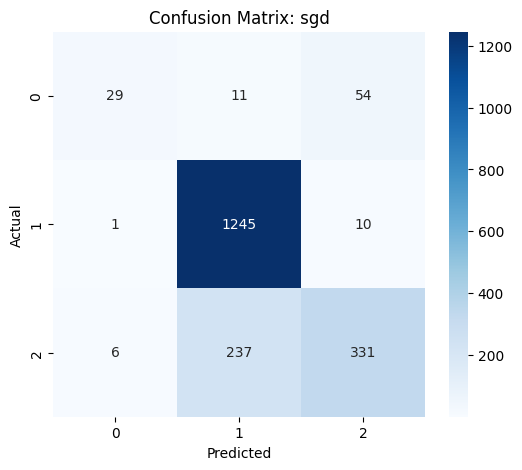


=== Training multinomial_nb ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'model__alpha': 1.0}
Metrics: {'accuracy': 0.5867983367983368, 'balanced_accuracy': 0.6499338574058693, 'log_loss': 1.9466160877362149, 'roc_auc': 0.803629932440917, 'f1_weighted': 0.6393948206819411}


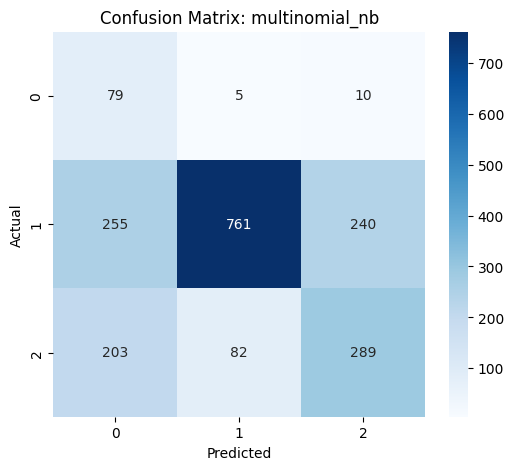


=== Training svm_rbf ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__C': 15.702970884055382, 'model__gamma': 0.015751320499779724}
Metrics: {'accuracy': 0.8471933471933472, 'balanced_accuracy': 0.8053982886739987, 'log_loss': 0.3545375325437887, 'roc_auc': 0.9359284140102829, 'f1_weighted': 0.8495891265478878}


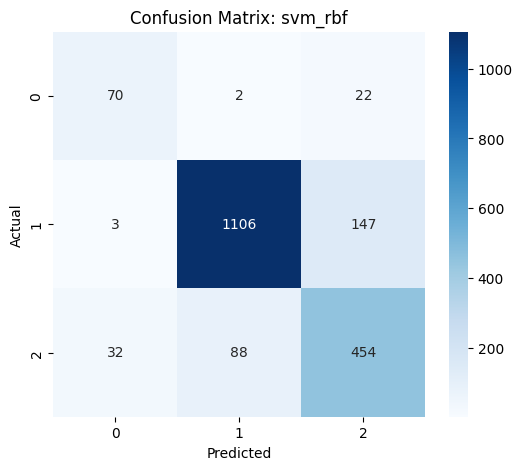


=== Training knn ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__n_neighbors': 49, 'model__p': 2, 'model__weights': 'uniform'}
Metrics: {'accuracy': 0.7707900207900208, 'balanced_accuracy': 0.5125358887220993, 'log_loss': 0.6091447103389632, 'roc_auc': 0.876047735482309, 'f1_weighted': 0.7369039651552686}


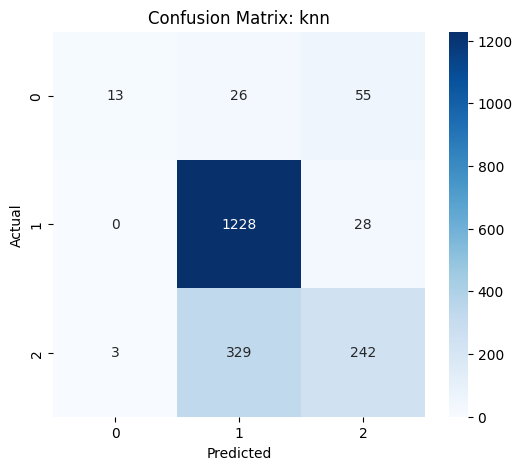


=== Training random_forest ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 351}
Metrics: {'accuracy': 0.8773388773388774, 'balanced_accuracy': 0.7629457138859234, 'log_loss': 0.31554603186345254, 'roc_auc': 0.9422171926137765, 'f1_weighted': 0.8699868426912488}


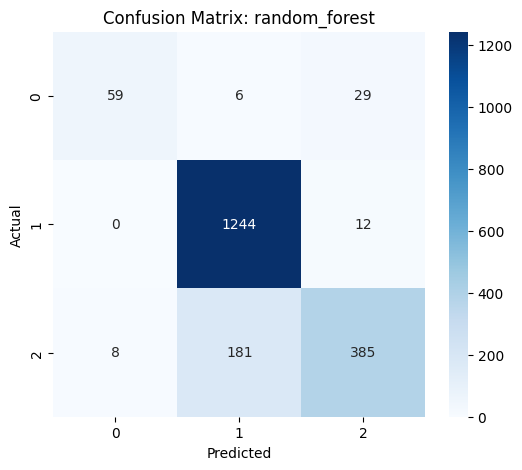


=== Training gradient_boosting ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__learning_rate': 0.0432845022129388, 'model__max_depth': 3, 'model__max_features': None, 'model__n_estimators': 206, 'model__subsample': 0.6}
Metrics: {'accuracy': 0.8768191268191268, 'balanced_accuracy': 0.7544148381342098, 'log_loss': 0.3212042793401188, 'roc_auc': 0.9410462189693072, 'f1_weighted': 0.8696008106436827}


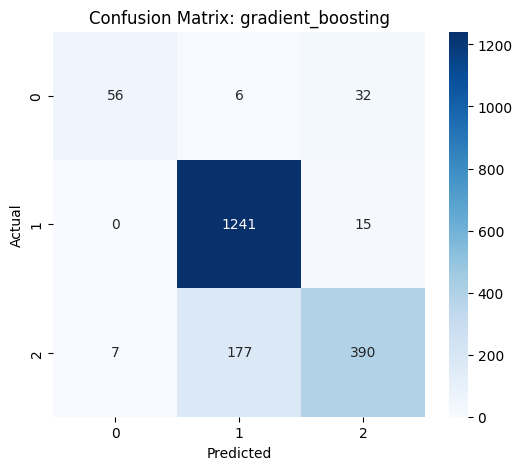


=== Training adaboost ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__learning_rate': 0.011120513715710632, 'model__n_estimators': 108}
Metrics: {'accuracy': 0.7806652806652806, 'balanced_accuracy': 0.4761904761904762, 'log_loss': 0.8305685827295468, 'roc_auc': 0.695102265996543, 'f1_weighted': 0.7374306041815539}


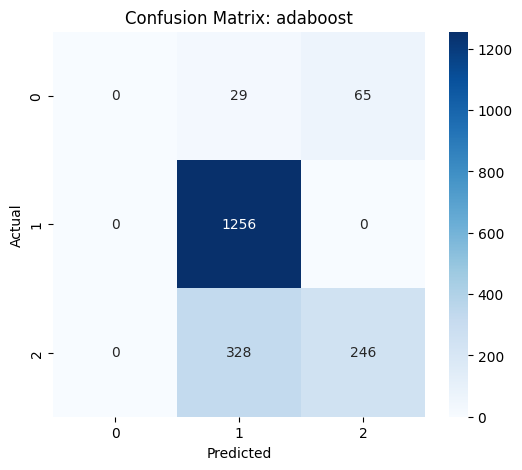


=== Summary Table ===


,Model,CV Score,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
5,random_forest,-0.309311,0.877339,0.762946,0.315546,0.942217,0.869987
6,gradient_boosting,-0.317122,0.876819,0.754415,0.321204,0.941046,0.869601
3,svm_rbf,-0.353681,0.847193,0.805398,0.354538,0.935928,0.849589
0,logistic,-0.334385,0.866424,0.751126,0.338445,0.934856,0.859603
1,sgd,-0.693913,0.834200,0.625469,0.969975,0.895980,0.816917
4,knn,-0.594522,0.770790,0.512536,0.609145,0.876048,0.736904
2,multinomial_nb,-1.836401,0.586798,0.649934,1.946616,0.803630,0.639395
7,adaboost,-0.825344,0.780665,0.476190,0.830569,0.695102,0.737431


In [ ]:
# train all models
# model_dict={'sgd': models['sgd'], 'logistic': models['logistic']}
results = train_and_evaluate(X_train, y_train_enc, X_test, y_test_enc, models)


# Optuna

In [14]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_optuna(X_train, y_train, X_test, y_test, model_dict, n_trials=20, cv=5, plot_confusion=True):
    results = {}
    summary_list = []

    feature_names = X_train.columns.tolist()

    for name, cfg in model_dict.items():
        print(f"\n=== Training {name} with Optuna ===")
        pipeline_template = build_pipeline(cfg['model'])
        param_space = cfg['params']

        def objective(trial):
            # Sample hyperparameters from the dictionary
            params = {}
            for k, v in param_space.items():
                if callable(v):
                    params[k.split("__")[-1]] = v(trial)
                else:
                    params[k.split("__")[-1]] = v

            # Clone pipeline and set classifier parameters
            pipeline = clone(pipeline_template)
            pipeline.named_steps['model'].set_params(**params)

            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
            scores = cross_val_score(
                pipeline, X_train, y_train,
                cv=skf, scoring='neg_log_loss', n_jobs=-1
            )
            return -scores.mean()  # Optuna minimizes

        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

        # Fit best model on full training set
        best_pipeline = clone(pipeline_template)
        best_pipeline.named_steps['model'].set_params(**study.best_params)
        best_pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = best_pipeline.predict(X_test)
        if hasattr(best_pipeline, "predict_proba"):
            y_proba = best_pipeline.predict_proba(X_test)
        else:
            # fallback for classifiers without predict_proba
            y_proba = np.zeros((len(y_pred), len(np.unique(y_train))))
            for i, label in enumerate(y_pred):
                y_proba[i, label] = 1

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'log_loss': log_loss(y_test, y_proba),
            'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted')
        }

        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        results[name] = {
            'best_model': best_pipeline,
            'best_params': study.best_params,
            'metrics': metrics,
            'confusion_matrix': cm
        }

        summary_list.append({
            'Model': name,
            'Accuracy': metrics['accuracy'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'Log Loss': metrics['log_loss'],
            'ROC AUC': metrics['roc_auc'],
            'F1 Weighted': metrics['f1_weighted']
        })

        print(f"Best params: {study.best_params}")
        print(f"Metrics: {metrics}")

        if plot_confusion:
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

    summary_df = pd.DataFrame(summary_list).sort_values(by='ROC AUC', ascending=False)
    print("\n=== Summary Table ===")
    display(summary_df)

    return results, summary_df


In [ ]:
from sklearn.linear_model import LogisticRegression

models_optuna = {
    'sgd': {
        'model': SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
        'params': {
            'model__alpha': lambda trial: trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
            'model__loss': lambda trial: trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
            'model__penalty': lambda trial: trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
        }
    },
       # =========================
    # LDA (solver-aware, SAFE)
    # =========================
    'lda': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'model__solver': lambda t: t.suggest_categorical(
                'solver', ['svd', 'lsqr']
            ),
            'model__shrinkage': lambda t: (
                'auto'
                if t.suggest_categorical('solver', ['svd', 'lsqr']) == 'lsqr'
                else None
            )
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': lambda t: t.suggest_int('n_neighbors', 3, 50),
            'model__weights': lambda t: t.suggest_categorical(
                'weights', ['uniform', 'distance']
            ),
            'model__p': lambda t: t.suggest_categorical(
                'p', [1, 2]  # Manhattan / Euclidean
            ),
            'model__leaf_size': lambda t: t.suggest_int('leaf_size', 20, 60)
        }
    },
    'logistic_lbfgs': {
        'model': LogisticRegression(
            solver='lbfgs',
            multi_class='multinomial',
            max_iter=5000,
            n_jobs=-1
        ),
        'params': {
            # Regularization strength
            'model__C': lambda trial: trial.suggest_float(
                'C', 1e-4, 1e3, log=True
            ),

            # Whether to include intercept
            'model__fit_intercept': lambda trial: trial.suggest_categorical(
                'fit_intercept', [True, False]
            ),

            # Numerical tolerance (affects convergence & speed)
            'model__tol': lambda trial: trial.suggest_float(
                'tol', 1e-6, 1e-2, log=True
            ),

            # Warm start can help when data is large
            'model__warm_start': lambda trial: trial.suggest_categorical(
                'warm_start', [True, False]
            ),

            # Penalty must be L2 or None
            'model__penalty': lambda trial: trial.suggest_categorical(
                'penalty', ['l2', None]
            ),
            'model__class_weight': lambda trial: trial.suggest_categorical(
                'class_weight',
                [None, 'balanced']
            )
        }
    },


    'logistic_saga': {
        'model': LogisticRegression(
            multi_class='multinomial',
            solver='saga',       # 'saga' supports l1, l2, elasticnet and multinomial
            max_iter=5000,
            n_jobs=-1
        ),
        'params': {
            # Regularization strength (log-scale search)
            'model__C': lambda trial: trial.suggest_float('C', 1e-4, 1e3, log=True),

            # Whether to fit the intercept
            'model__fit_intercept': lambda trial: trial.suggest_categorical('fit_intercept', [True, False]),

            # Regularization type: l1, l2, or elasticnet
            'model__penalty': lambda trial: trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),

            # ElasticNet mixing ratio (only used if penalty='elasticnet')
            'model__l1_ratio': lambda trial: trial.suggest_float('l1_ratio', 0.0, 1.0),  # ignored if not elasticnet
            'model__class_weight': lambda trial: trial.suggest_categorical(
                'class_weight',
                [None, 'balanced']
            )

            # Solver is fixed to 'saga' because it supports all penalties and multinomial
        }
    },

    
 

    'svm_rbf': {
        'model': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
        'params': {
            'model__C': lambda trial: trial.suggest_float('C', 0.1, 100, log=True),
            'model__gamma': lambda trial: trial.suggest_float('gamma', 1e-3, 0.1, log=True)
        }
    },


    # 'svm_linear': {
    #     'model': SVC(
    #         kernel='linear',
    #         probability=True,
    #         class_weight='balanced',
    #         random_state=42
    #     ),
    #     'params': {
    #         'model__C': lambda t: t.suggest_float('C', 1e-2, 1e2, log=True)
    #     }
    # },
    # 'svm_poly': {
    #     'model': SVC(
    #         kernel='poly',
    #         probability=True,
    #         class_weight='balanced',
    #         random_state=42
    #     ),
    #     'params': {
    #         'model__C': lambda t: t.suggest_float('C', 1e-2, 1e2, log=True),
    #         'model__degree': lambda t: t.suggest_int('degree', 2, 3),
    #         'model__gamma': lambda t: t.suggest_float('gamma', 1e-3, 1e-1, log=True),
    #         'model__coef0': lambda t: t.suggest_float('coef0', 0.0, 1.0)
    #     }
    # },
}




In [18]:
results, summary_df = train_and_evaluate_optuna(X_train, y_train_enc, X_test, y_test_enc, models_optuna, plot_confusion=False)


[I 2026-01-03 21:51:51,262] A new study created in memory with name: no-name-09102174-6625-49f1-8cea-36948a4eeaff



=== Training sgd with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 21:51:53,429] Trial 0 finished with value: 0.3963275261744404 and parameters: {'alpha': 0.0053082077083211, 'loss': 'log_loss', 'penalty': 'l2'}. Best is trial 0 with value: 0.3963275261744404.
[I 2026-01-03 21:51:56,250] Trial 1 finished with value: 0.38315781956200234 and parameters: {'alpha': 0.0012159542754480682, 'loss': 'log_loss', 'penalty': 'elasticnet'}. Best is trial 1 with value: 0.38315781956200234.
[I 2026-01-03 21:51:58,116] Trial 2 finished with value: 0.8384383463978619 and parameters: {'alpha': 0.007782396800720999, 'loss': 'modified_huber', 'penalty': 'elasticnet'}. Best is trial 1 with value: 0.38315781956200234.
[I 2026-01-03 21:51:59,277] Trial 3 finished with value: 0.9053574737914669 and parameters: {'alpha': 0.0044444659683805085, 'loss': 'modified_huber', 'penalty': 'l2'}. Best is trial 1 with value: 0.38315781956200234.
[I 2026-01-03 21:52:00,613] Trial 4 finished with value: 0.5537880161792167 and parameters: {'alpha': 0.04840898645869395, 'loss

[I 2026-01-03 21:52:29,059] A new study created in memory with name: no-name-22864e2d-79a5-4f87-9bc4-c3a093056b44


Best params: {'alpha': 0.0003534991180027791, 'loss': 'log_loss', 'penalty': 'l2'}
Metrics: {'accuracy': 0.8404365904365905, 'balanced_accuracy': 0.6603876060685762, 'log_loss': 0.3870347383004833, 'roc_auc': 0.9182573691707882, 'f1_weighted': 0.8266639456371981}

=== Training lda with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 21:52:29,839] Trial 0 finished with value: 0.497493504259214 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.497493504259214.
[I 2026-01-03 21:52:30,387] Trial 1 finished with value: 0.4947163855435397 and parameters: {'solver': 'lsqr'}. Best is trial 1 with value: 0.4947163855435397.
[I 2026-01-03 21:52:30,908] Trial 2 finished with value: 0.4947163855435397 and parameters: {'solver': 'lsqr'}. Best is trial 1 with value: 0.4947163855435397.
[I 2026-01-03 21:52:31,726] Trial 3 finished with value: 0.497493504259214 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.4947163855435397.
[I 2026-01-03 21:52:32,496] Trial 4 finished with value: 0.497493504259214 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.4947163855435397.
[I 2026-01-03 21:52:33,250] Trial 5 finished with value: 0.497493504259214 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.4947163855435397.
[I 2026-01-03 21:52:33,810] Trial 6 finished with

[I 2026-01-03 21:52:42,199] A new study created in memory with name: no-name-b9b86a22-fc42-4ee2-a5c9-0102f81ede2c


Best params: {'solver': 'lsqr'}
Metrics: {'accuracy': 0.827962577962578, 'balanced_accuracy': 0.7292930474607052, 'log_loss': 0.7405560642533994, 'roc_auc': 0.9212062383116177, 'f1_weighted': 0.8101403558723862}

=== Training knn with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 21:52:43,598] Trial 0 finished with value: 0.5788782659948871 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'p': 1, 'leaf_size': 40}. Best is trial 0 with value: 0.5788782659948871.
[I 2026-01-03 21:52:44,117] Trial 1 finished with value: 0.8233561928742207 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2, 'leaf_size': 43}. Best is trial 0 with value: 0.5788782659948871.
[I 2026-01-03 21:52:44,639] Trial 2 finished with value: 2.51040604616339 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2, 'leaf_size': 32}. Best is trial 0 with value: 0.5788782659948871.
[I 2026-01-03 21:52:45,149] Trial 3 finished with value: 1.1449185649769258 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2, 'leaf_size': 52}. Best is trial 0 with value: 0.5788782659948871.
[I 2026-01-03 21:52:45,698] Trial 4 finished with value: 1.606367848768743 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2, 'leaf_size': 44}. Best is tri

[I 2026-01-03 21:53:03,872] A new study created in memory with name: no-name-c0590684-5d62-4f2f-9115-94010b197cb2


Best params: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'leaf_size': 60}
Metrics: {'accuracy': 0.8373180873180873, 'balanced_accuracy': 0.6654171229242541, 'log_loss': 0.49060542442723587, 'roc_auc': 0.9254443595965878, 'f1_weighted': 0.8261359086290302}

=== Training logistic_lbfgs with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 21:53:19,615] Trial 0 finished with value: 0.4334510177441837 and parameters: {'C': 3.6221401759344767, 'fit_intercept': False, 'tol': 6.753176114316847e-06, 'warm_start': False, 'penalty': None, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4334510177441837.
[I 2026-01-03 21:53:20,691] Trial 1 finished with value: 0.35391025998292824 and parameters: {'C': 0.02291683668984255, 'fit_intercept': False, 'tol': 1.9319970514527534e-06, 'warm_start': True, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.35391025998292824.
[I 2026-01-03 21:53:22,257] Trial 2 finished with value: 0.3412992461311394 and parameters: {'C': 0.1901725359073825, 'fit_intercept': False, 'tol': 3.3600727008432402e-06, 'warm_start': True, 'penalty': 'l2', 'class_weight': None}. Best is trial 2 with value: 0.3412992461311394.
[I 2026-01-03 21:53:29,222] Trial 3 finished with value: 0.42532055661971235 and parameters: {'C': 58.40375423681813, 'fit_intercept': False, 'tol':

,Model,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
3,logistic_lbfgs,0.867464,0.749953,0.352109,0.932795,0.860929
2,knn,0.837318,0.665417,0.490605,0.925444,0.826136
1,lda,0.827963,0.729293,0.740556,0.921206,0.810140
0,sgd,0.840437,0.660388,0.387035,0.918257,0.826664


# with minmax and standardscaler

In [19]:
results, summary_df = train_and_evaluate_optuna(X_train, y_train_enc, X_test, y_test_enc, models_optuna, plot_confusion=False)


[I 2026-01-03 22:30:46,974] A new study created in memory with name: no-name-5397739d-5c72-4949-afb5-3a2ab6881580



=== Training sgd with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2026-01-03 22:30:49,315] Trial 0 failed with parameters: {'alpha': 0.0025543329289440314, 'loss': 'hinge', 'penalty': 'elasticnet'} because of the following error: The value nan is not acceptable.
[W 2026-01-03 22:30:49,316] Trial 0 failed with value nan.
[W 2026-01-03 22:30:51,404] Trial 1 failed with parameters: {'alpha': 0.04330842498072662, 'loss': 'hinge', 'penalty': 'l1'} because of the following error: The value nan is not acceptable.
[W 2026-01-03 22:30:51,405] Trial 1 failed with value nan.
[W 2026-01-03 22:30:54,197] Trial 2 failed with parameters: {'alpha': 1.1412100914437953e-05, 'loss': 'hinge', 'penalty': 'elasticnet'} because of the following error: The value nan is not acceptable.
[W 2026-01-03 22:30:54,198] Trial 2 failed with value nan.
[I 2026-01-03 22:30:55,392] Trial 3 finished with value: 0.40376589764436366 and parameters: {'alpha': 0.009485601230201564, 'loss': 'log_loss', 'penalty': 'l2'}. Best is trial 3 with value: 0.40376589764436366.
[I 2026-01-03 22:30:

[I 2026-01-03 22:31:31,923] A new study created in memory with name: no-name-d75a5e2c-cb10-41fc-96f9-ed84f4546d2d


Best params: {'alpha': 0.008381898733778162, 'loss': 'log_loss', 'penalty': 'l2'}
Metrics: {'accuracy': 0.841995841995842, 'balanced_accuracy': 0.6760106804018499, 'log_loss': 0.4180225957758175, 'roc_auc': 0.9114942627043834, 'f1_weighted': 0.828154154021634}

=== Training lda with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 22:31:32,494] Trial 0 finished with value: 0.4947163855435397 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4947163855435397.
[I 2026-01-03 22:31:33,203] Trial 1 finished with value: 0.497493504259214 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4947163855435397.
[I 2026-01-03 22:31:33,742] Trial 2 finished with value: 0.4947163855435397 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4947163855435397.
[I 2026-01-03 22:31:34,257] Trial 3 finished with value: 0.4947163855435397 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4947163855435397.
[I 2026-01-03 22:31:34,792] Trial 4 finished with value: 0.4947163855435397 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4947163855435397.
[I 2026-01-03 22:31:35,517] Trial 5 finished with value: 0.497493504259214 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4947163855435397.
[I 2026-01-03 22:31:36,056] Trial 6 finished

[I 2026-01-03 22:31:44,155] A new study created in memory with name: no-name-7dc227ef-c43c-4d8c-8e23-20b4bc323eca


Best params: {'solver': 'lsqr'}
Metrics: {'accuracy': 0.827962577962578, 'balanced_accuracy': 0.7292930474607052, 'log_loss': 0.7405560642533994, 'roc_auc': 0.9212062383116177, 'f1_weighted': 0.8101403558723862}

=== Training knn with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 22:31:45,330] Trial 0 finished with value: 0.6091630074043689 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'p': 1, 'leaf_size': 54}. Best is trial 0 with value: 0.6091630074043689.
[I 2026-01-03 22:31:45,871] Trial 1 finished with value: 0.6568263489071446 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 2, 'leaf_size': 33}. Best is trial 0 with value: 0.6091630074043689.
[I 2026-01-03 22:31:47,107] Trial 2 finished with value: 0.6493431457930113 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1, 'leaf_size': 42}. Best is trial 0 with value: 0.6091630074043689.
[I 2026-01-03 22:31:48,441] Trial 3 finished with value: 0.6337659290779403 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1, 'leaf_size': 42}. Best is trial 0 with value: 0.6091630074043689.
[I 2026-01-03 22:31:49,660] Trial 4 finished with value: 0.9186164349560872 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1, 'leaf_size': 37}. Best 

[I 2026-01-03 22:32:00,020] A new study created in memory with name: no-name-ea1c9a88-59ef-43b6-ae59-f583c3b40cd3


Best params: {'n_neighbors': 50, 'weights': 'distance', 'p': 2, 'leaf_size': 20}
Metrics: {'accuracy': 0.8440748440748441, 'balanced_accuracy': 0.6895579105975947, 'log_loss': 0.46700542865879024, 'roc_auc': 0.9266714011661003, 'f1_weighted': 0.8360285216961131}

=== Training logistic_lbfgs with Optuna ===


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-03 22:32:00,655] Trial 0 finished with value: 0.4323697258533287 and parameters: {'C': 0.011108574279703763, 'fit_intercept': True, 'tol': 0.003663816184852248, 'warm_start': False, 'penalty': None, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4323697258533287.
[I 2026-01-03 22:32:10,937] Trial 1 finished with value: 0.3532640431339849 and parameters: {'C': 11.342083541166117, 'fit_intercept': False, 'tol': 9.811266319574419e-06, 'warm_start': False, 'penalty': None, 'class_weight': None}. Best is trial 1 with value: 0.3532640431339849.
[I 2026-01-03 22:32:11,442] Trial 2 finished with value: 0.6001020622431383 and parameters: {'C': 0.0003472753861195066, 'fit_intercept': True, 'tol': 0.008695927974643221, 'warm_start': True, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.3532640431339849.
[I 2026-01-03 22:32:12,125] Trial 3 finished with value: 0.347845660365245 and parameters: {'C': 35.542963100392065, 'fit_intercept': True, 'tol'

,Model,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
3,logistic_lbfgs,0.866944,0.752653,0.354738,0.934392,0.860486
2,knn,0.844075,0.689558,0.467005,0.926671,0.836029
1,lda,0.827963,0.729293,0.740556,0.921206,0.810140
0,sgd,0.841996,0.676011,0.418023,0.911494,0.828154


In [17]:
# Top 3 models by ROC AUC
top_models = summary_df.sort_values(by='ROC AUC', ascending=False).head(3)
print(top_models)


           Model  Accuracy  Balanced Accuracy  Log Loss   ROC AUC  F1 Weighted
6       svm_poly  0.843555           0.782152  0.347566  0.935105     0.845985
5        svm_rbf  0.841996           0.768233  0.356540  0.934509     0.844082
4  logistic_saga  0.870062           0.757526  0.354306  0.934403     0.863523


In [32]:
top_models

,Model,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
6,svm_poly,0.843555,0.782152,0.347566,0.935105,0.845985
5,svm_rbf,0.841996,0.768233,0.356540,0.934509,0.844082
4,logistic_saga,0.870062,0.757526,0.354306,0.934403,0.863523
